## Section I - Length and Count Plots

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

df = pd.read_csv('../data/data_complete.csv')

In [5]:
df['source'].unique()

array(['osdg', 'hal', 'UN', 'scraped', 'paper'], dtype=object)

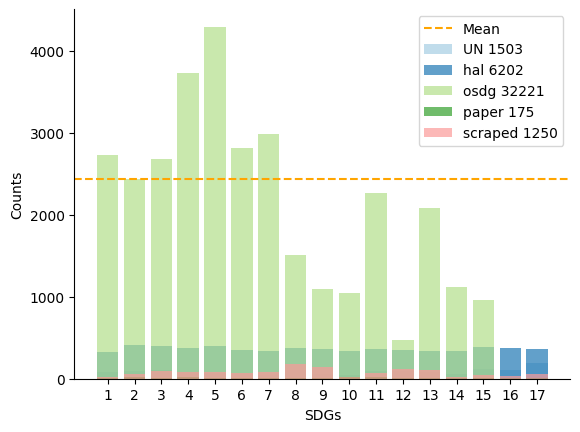

In [16]:
# group and count text apperances of sdg and source column values in df
sdg_counts = df.groupby(['sdg', 'source']).count()['text'].unstack().fillna(0)

fig, ax = plt.subplots()

ax.set_xlabel("SDGs")
ax.set_ylabel("Counts")


# add average line
mean = sdg_counts.values.sum() / 17
ax.axhline(mean, label="Mean", color="orange", linestyle="--")

# set color palette
colors = sns.color_palette("Paired", n_colors=len(sdg_counts.columns))

# plot each source as a separate bar plot with a different color
for i, col in enumerate(sdg_counts.columns):
    ax.bar(sdg_counts.index, sdg_counts[col], width=0.8, color=colors[i % len(colors)], alpha=0.7, label=f"{col} {int(sdg_counts[col].sum())}")

ax.legend()

# remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set xticks for each SDG
plt.xticks(sdg_counts.index)

# save plot as pdf
# plt.savefig('./plots/sdg_counts.pdf', bbox_inches='tight')

plt.show()


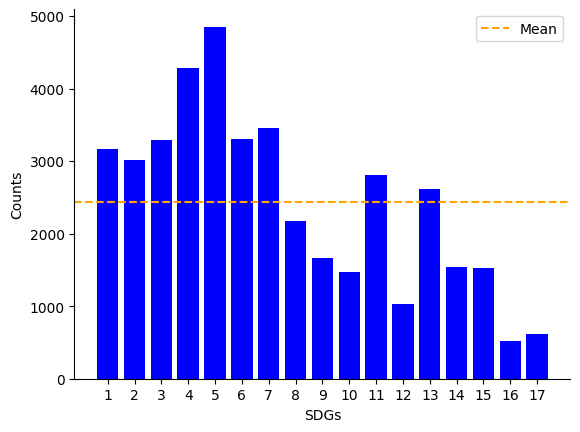

In [17]:
# Group and count text appearances of 'sdg' column values in df
sdg_counts = df.groupby('sdg').count()['text'].to_frame().rename(columns={'text': 'count'})

# Create a new figure and axis object
fig, ax = plt.subplots()

# Set axis labels
ax.set_xlabel("SDGs")
ax.set_ylabel("Counts")

# Add average line to the plot
mean = sdg_counts["count"].mean()
ax.axhline(mean, label="Mean", color="orange", linestyle="--")

# Add legend to the plot
ax.legend()

# Set the x-tick labels to the SDG values
plt.xticks(sdg_counts.index)

# Plot a bar chart of the count values for each SDG
plt.bar(sdg_counts.index, sdg_counts["count"], width=0.8, color="blue")

# Remove the top and right borders from the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot as a PDF file (optional)
# plt.savefig('./plots/sdg_counts.pdf', bbox_inches='tight')

# Display the plot
plt.show()


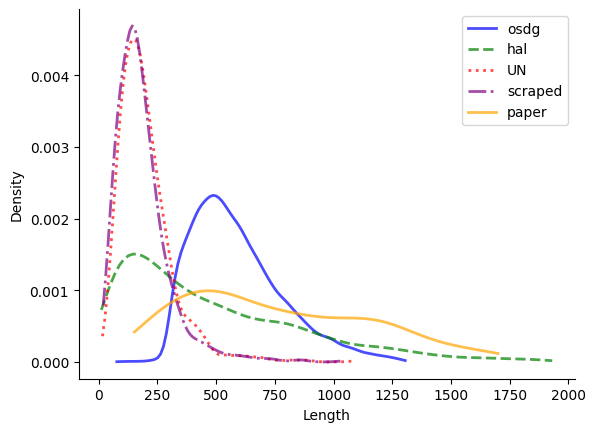

In [14]:
df['length'] = df['text'].str.len()

# define a list of colors and linestyles
colors = ['blue', 'green', 'red', 'purple', 'orange']
linestyles = ['-', '--', ':', '-.', '-', '--']

# get the unique sources in the dataframe
sources = df['source'].unique()

# create a figure and axis object
fig, ax = plt.subplots()

# loop through each source and plot the kde with a different color and linestyle
for i, source in enumerate(sources):
    subset = df[df['source']==source]
    lengths = subset['length']
    kde = gaussian_kde(lengths)
    x = np.linspace(lengths.min(), lengths.max(), 100)
    ax.plot(x, kde(x), label=source, linestyle=linestyles[i % len(linestyles)], linewidth=2, color=colors[i % len(colors)], alpha=0.7, zorder=10)

# set axis labels and legend
ax.set_xlabel('Length')
ax.set_ylabel('Density')
ax.legend()

#remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#save plot as pdf
# plt.savefig('./plots/length_distribution.pdf', bbox_inches='tight')

# display the plot
plt.show()


## Section II - Word Frequencies

In [40]:
import pandas as pd
import nltk
from nltk.corpus import wordnet, stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thenizamoglu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thenizamoglu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/thenizamoglu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [19]:
sdgs = {1: "No Poverty", 2: "Zero Hunger", 3: "Good Health and Well-being", 4: "Qaulity Education", 5: "Gender Equality", 6: "Clean Water and Sanitation", 7: "Affordable and Clean Energy", 8: "Decent Work and Economic Growth", 9: "Industry, Innovation and Infrastructure", 10: "Reduced Inequalities", 11: "Sustainable Cities and Communities", 12: "Responsable Consumption and Production", 13: "Climate Action", 14: "Life Below Water", 15: "Life on Land", 16: "Peace, Justice and Strong Institutions", 17: "Partnerships for the Goals"}

In [45]:
stopword_list = stopwords.words("english")

# Map POS tags to WordNet tags
def get_wordnet_pos(pos_tag):
    tag = pos_tag[0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text, stem=False, lemmatize=True, stop_words=stopword_list):
    # Convert to lowercase and remove punctuations and characters, then strip
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # Tokenize (convert from string to list)
    words = text.split()    
    
    # Remove stopwords
    if stop_words:
        words = [word for word in words if word not in stop_words]
    
    # Lemmatization (convert the word into root word)
    if lemmatize:
        lemmatizer = nltk.stem.WordNetLemmatizer()
        pos_tags = nltk.pos_tag(words)
        words = [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in pos_tags]

    # Stemming (remove -ing, -ly, ...)
    if stem:
        stemmer = nltk.stem.PorterStemmer()
        words = [stemmer.stem(word) for word in words]

    # Convert back to string from list
    text = " ".join(words)
    
    return text


In [38]:
def get_top_n_words(corpus, n=None, ngram_range=1):
    # CountVectorizer to create a document-term matrix for the given corpus
    vec = CountVectorizer(ngram_range=(ngram_range, ngram_range)).fit(corpus)
    
    # Transform corpus into bag-of-words representation
    bag_of_words = vec.transform(corpus)
    
    # Sum the counts of each word over the entire corpus
    sum_words = bag_of_words.sum(axis=0)
    
    # Create a list of (word, frequency) tuples and sort them in descending order by frequency
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Return the top n words with their frequencies
    return words_freq[:n]

def visualise_ngrams(SDG, common_words, print_text=False):
    # Sort the common words in descending order by frequency
    common_words = sorted(common_words, key=lambda x: x[1], reverse=True)
    
    # If print_text is True, print the common words and their frequencies
    if print_text:
        for word, freq in common_words:
            print(word, freq)

    # Create a DataFrame from the common words and their frequencies
    df2 = pd.DataFrame(common_words, columns=['words', 'count'])
    
    # Create a bar plot of the common words and their frequencies
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(df2['words'], df2['count'])
    plt.xticks(rotation=90)
    
    # Set the plot title to the SDG name
    plt.title(sdgs[SDG])
    
    # Show the plot
    plt.show()

def get_word_counts(SDG: int, visualize: bool=False, ngram_range=1, df = pd.DataFrame):
    # Get the cleaned text for the given SDG and find the top 100 words and their frequencies
    common_words = get_top_n_words(df.loc[df['sdg'] == SDG]['text_clean'], 100, ngram_range=ngram_range)
    
    # If visualize is True, visualize the top 30 words and their frequencies
    if visualize:
        visualise_ngrams(SDG, common_words[:30])
    
    # Return the top 100 words and their frequencies
    return common_words


In [47]:
df['text_clean'] = df['text'].progress_apply(lambda x: preprocess_text(x))

100%|██████████| 41351/41351 [02:30<00:00, 274.48it/s]


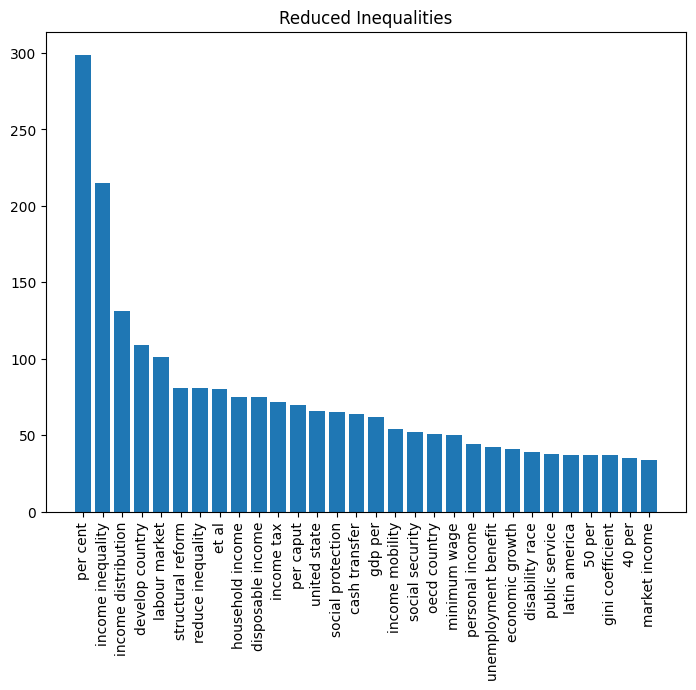

In [48]:
#play around with word count
common_words = get_word_counts(10, True, 2, df)